# Extreme Events EDA

Goals: explore how extreme climate events affect GPP and how plants memorize extreme events and change response moving forward

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore
from sklearn.cluster import KMeans

# Set paths
wd = '/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling/'
data = wd + 'data/datasets/'
hh_data = data + 'half_hourly/'
code = wd + 'code/src/'

### 1. GPP Extremes

#### 1.1 Load Site Data, Parse Dates

In [2]:
# Load one site
site = os.listdir(hh_data)[1]
site_df = pd.read_csv(hh_data + site)
site_name = site.split('_')[-1][:-4]

# Parse start time
def parse_timestamp(timestamp):
    year = int(timestamp[0:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])
    hour = int(timestamp[8:10])
    mins = int(timestamp[10:12])
    return year, month, day, hour, mins

site_df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINS']] = \
    site_df['TIMESTAMP_START'].astype(str).apply(parse_timestamp).apply(pd.Series)

# Display
print(f"Site: {site_name}")
site_df.head()

Site: CN-HaM


,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,b5,b6,b7,IGBP,koppen,YEAR,MONTH,DAY,HOUR,MINS
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,0.5601,0.1609,0.0708,GRA,Polar,2002,1,15,0,0
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,0.5601,0.1609,0.0708,GRA,Polar,2002,1,15,0,30
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,0.5601,0.1609,0.0708,GRA,Polar,2002,1,15,1,0
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,0.5601,0.1609,0.0708,GRA,Polar,2002,1,15,1,30
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,0.5601,0.1609,0.0708,GRA,Polar,2002,1,15,2,0


#### 1.2 Create Season and 4-Hour Time-of-Day Groups

In [3]:
def define_season_tod(predictors, target='GPP_NT_VUT_REF', df=site_df):
    # Season indicator
    df['SEASON'] = ''
    df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON'] = 'WINTER'
    df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON'] = 'SPRING'
    df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON'] = 'SUMMER'
    df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON'] = 'FALL'

    # 6-Hour TOD indicator
    df['TOD_GROUP'] = ''
    df.loc[df['HOUR'].isin(list(range(0, 6))), 'TOD_GROUP'] = '1'
    df.loc[df['HOUR'].isin(list(range(6, 12))), 'TOD_GROUP'] = '2'
    df.loc[df['HOUR'].isin(list(range(12, 18))), 'TOD_GROUP'] = '3'
    df.loc[df['HOUR'].isin(list(range(18, 24))), 'TOD_GROUP'] = '4'

    # Merge to define season-TOD groups
    df['SEASON_TOD'] = df['SEASON'] + '_' + df['TOD_GROUP']

    # Create GPP_extreme indicator to fill in later
    for feat in predictors:
        df['Z_' + feat] = 0
    df['Z_' + target] = 0
    df['EXT_IND_' + target] = 0

    return df


# Apply
predictors = ['TA_ERA', 'P_ERA', 'VPD_ERA', 'SW_IN_ERA', 'NDVI', 'EVI', 'NIRv'] # <--- smaller set for now
target = 'GPP_NT_VUT_REF'
site_df = define_season_tod(predictors, target, site_df)
site_df.head()


,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,SEASON_TOD,Z_TA_ERA,Z_P_ERA,Z_VPD_ERA,Z_SW_IN_ERA,Z_NDVI,Z_EVI,Z_NIRv,Z_GPP_NT_VUT_REF,EXT_IND_GPP_NT_VUT_REF
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,WINTER_1,0,0,0,0,0,0,0,0,0
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,WINTER_1,0,0,0,0,0,0,0,0,0
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,WINTER_1,0,0,0,0,0,0,0,0,0
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,WINTER_1,0,0,0,0,0,0,0,0,0
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,WINTER_1,0,0,0,0,0,0,0,0,0


#### 1.3 Get Z-Values for each feature within SEASON_TOD group, identify extreme GPP events (z >= 3 std devs)

In [4]:
def find_extremes(st_group, predictors, target, df=site_df):
    # Subset df to SEASON_TOD group
    subset = df[df['SEASON_TOD']==st_group].copy()

    # Get z-scores for each record within ST group context
    for feat in predictors:
        arr = subset[feat]
        z = zscore(arr)
        df.loc[list(z.index), 'Z_' + feat] = z

    # Get GPP z-scores and identify extreme events
    arr = subset[target]
    z = zscore(arr)
    df.loc[list(z.index), 'Z_' + target] = z
    outliers = np.where(np.abs(z) > 3)

    # Write GPP outliers to extreme_indicator var
    if len(outliers[0]) > 0:
        inds = outliers[0]
        df.loc[inds, 'EXT_IND_' + target] = 1

    return df


st_groups = site_df['SEASON_TOD'].unique()
for st in st_groups:
    site_df = find_extremes(st, predictors, target, site_df)

In [5]:
site_df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,SEASON_TOD,Z_TA_ERA,Z_P_ERA,Z_VPD_ERA,Z_SW_IN_ERA,Z_NDVI,Z_EVI,Z_NIRv,Z_GPP_NT_VUT_REF,EXT_IND_GPP_NT_VUT_REF
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,WINTER_1,0.726463,3.473080,-0.922183,NaN,NaN,NaN,NaN,0.508151,0
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,WINTER_1,0.705383,3.473080,-0.891229,NaN,NaN,NaN,NaN,-0.002282,0
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,WINTER_1,0.684302,3.473080,-0.862485,NaN,NaN,NaN,NaN,-0.193739,1
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,WINTER_1,0.663446,-0.173434,-0.833742,NaN,NaN,NaN,NaN,0.956410,0
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,WINTER_1,0.642366,-0.173434,-0.804999,NaN,NaN,NaN,NaN,0.995102,0


#### 1.4 Naive investigation to common trends in extreme events

In [17]:
# Is average GPP extreme positive or negative?
site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, 'Z_GPP_NT_VUT_REF'].mean()

-0.12494376938751749

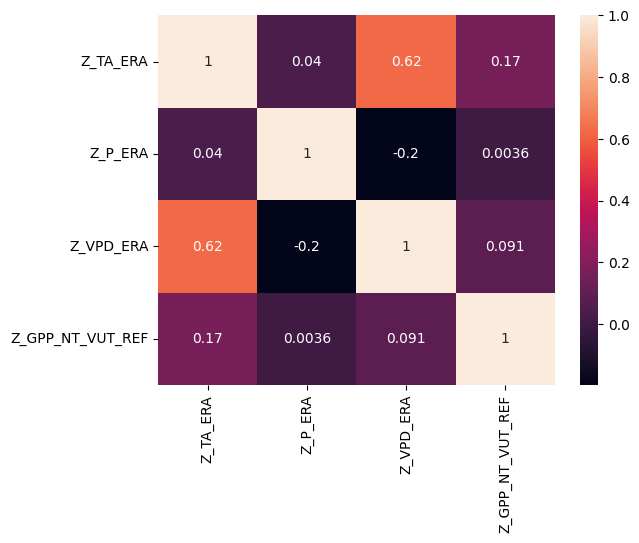

In [14]:
# Which feature is most correlated with GPP extreme events?
corr = site_df[['Z_TA_ERA', 'Z_P_ERA', 'Z_VPD_ERA', 'Z_GPP_NT_VUT_REF']].corr()
sns.heatmap(corr, annot=True)
plt.show()


In [16]:
# Find average Z-score of predictor features for extreme GPP events
site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, ['Z_TA_ERA', 'Z_P_ERA', 'Z_VPD_ERA']].mean()

Z_TA_ERA    -0.308668
Z_P_ERA     -0.044609
Z_VPD_ERA   -0.137895
dtype: float64

#### 1.5 Cluster extreme events to see common types based on features

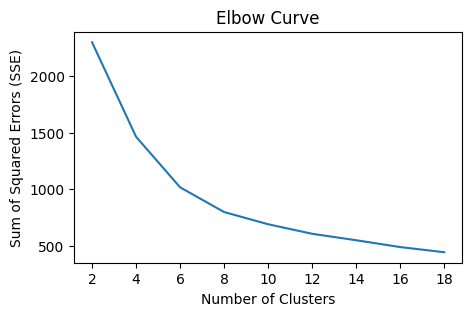

In [33]:
## FIRST, FIND OPTIMAL N_CLUSTERS
# subset to extreme GPP events
clust_feats = ['Z_TA_ERA', 'Z_P_ERA', 'Z_VPD_ERA', 'Z_GPP_NT_VUT_REF']
ext_gpp = site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, clust_feats].copy()

def find_elbow_curve(df):
    SSE = []
    for n_clusters in range(2, 20, 2):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        kmeans.fit(df)
        SSE.append(kmeans.inertia_)

    plt.figure(figsize=(5, 3))
    plt.plot(range(2, 20, 2), SSE)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.title("Elbow Curve")
    plt.show()

find_elbow_curve(ext_gpp)

In [34]:
# subset to extreme GPP events
n_clusters = 8
clust_feats = ['Z_TA_ERA', 'Z_P_ERA', 'Z_VPD_ERA', 'Z_GPP_NT_VUT_REF']
ext_gpp = site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, clust_feats].copy()

# cluster based on climate vars to find common themes
def k_means(df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(df)
    return kmeans.cluster_centers_, kmeans.labels_

centers, labels = k_means(ext_gpp, n_clusters)

# investigate diff clustesr
centers_df = pd.DataFrame(centers, columns=clust_feats)
centers_df.index = ["cluster_" + str(i) for i in range(n_clusters)]
centers_df.sort_values('Z_GPP_NT_VUT_REF', inplace=True)
print(centers_df)

           Z_TA_ERA   Z_P_ERA  Z_VPD_ERA  Z_GPP_NT_VUT_REF
cluster_7  0.010266 -0.170332  -0.583246         -6.156738
cluster_2 -0.516579 -0.141889  -0.380817         -1.755562
cluster_3  0.454364  3.065864  -0.363278         -0.527443
cluster_0  2.270799 -0.100012   2.952044         -0.484124
cluster_6  1.017657 -0.095767   0.666634         -0.069071
cluster_1 -1.211930 -0.172322  -0.673358          0.019515
cluster_4 -0.185611 -0.192972  -0.057696          0.224733
cluster_5 -0.606275 -0.086580  -0.596474          2.046786
